In [1]:
import os
import numpy as np
import pandas as pd
import p2pspatial
import pulse2percept.implants as p2pi
import pulse2percept.utils as p2pu
from pulse2percept.retina import dva2ret, ret2dva
import pyswarm

import sklearn.base as sklb

import matplotlib.pyplot as plt
%matplotlib inline

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-24 16:15:31,965 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
use_trafo = False

In [3]:
subject_params = {
    'TB': {
        'implant_type': p2pi.ArgusI,
        'implant_x': -1527,
        'implant_y': -556,
        'implant_rot': -1.13,
        'loc_od_x': 13.6,
        'loc_od_y': 0.0,
        'xrange': (-36.9, 36.9),
        'yrange': (-36.9, 36.9)
    },
    '12-005': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1761,
        'implant_y': -212,
        'implant_rot': -0.188,
        'loc_od_x': 15.4,
        'loc_od_y': 1.86,
        'xrange': (-30, 30),
        'yrange': (-22.5, 22.5)
    },
    '51-009': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -799,
        'implant_y': 93,
        'implant_rot': -1.09,
        'loc_od_x': 15.7,
        'loc_od_y': 0.75,
        'xrange': (-32.5, 32.5),
        'yrange': (-24.4, 24.4)
    },
    '52-001': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1230,
        'implant_y': 415,
        'implant_rot': -0.457,
        'loc_od_x': 15.9,
        'loc_od_y': 1.96,
        'xrange': (-32, 32),
        'yrange': (-24, 24)
    }
}

use_electrodes = {
    'TB': ['A4', 'C2', 'C3', 'C4', 'D2', 'D3', 'B3', 'D4'],
    '12-005': ['A04', 'A06', 'B03', 'C07', 'C10', 'D07', 'D08', 'D10',
               'F06'],
    '51-009': ['A02', 'B03', 'B04', 'C01', 'C05', 'C06', 'C08', 'D03',
               'E01', 'E05', 'E07', 'E09', 'F04', 'F06'],
    '52-001': ['A05', 'A07', 'B09', 'A10', 'C10', 'D05', 'D07', 'E04',
               'E09', 'E10', 'F06', 'F07', 'F08', 'F09', 'F10']
}

In [4]:
subject = '52-001'
X, y = p2pspatial.load_data(os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape'), subject=subject,
                            amplitude=2.0, electrodes=use_electrodes[subject])
Xy = pd.concat((X, y.drop(columns='electrode')), axis=1)

In [5]:
if use_trafo:
    trafo = p2pspatial.models.ModelB()
    
y_true = []
for _, row in Xy.iterrows():
    props = p2pspatial.imgproc.get_region_props(row['image'], thresh=0.1)
    xrange = subject_params[subject]['xrange']
    yrange = subject_params[subject]['yrange']
    x_center = props.centroid[1] / row['img_shape'][1] * np.diff(xrange)[0] + xrange[0]
    y_center = props.centroid[0] / row['img_shape'][0] * np.diff(yrange)[0] + yrange[0]
    if use_trafo:
        xy = trafo._displaces_rgc(np.array([[x_center, y_center]]))
        xy = (xy[0][0], xy[1][0])
    else:
        xy = (288*x_center, 288*y_center)
        xy = dva2ret((x_center, y_center))
    y_true.append({'x_center': xy[0], 'y_center': xy[1]})
y_true = pd.DataFrame(y_true, index=y.index)

In [6]:
electrodes = list(X.electrode.unique())

In [7]:
class ImplantPlacement(sklb.BaseEstimator):
    def __init__(self, x_center=0, y_center=0, rot=0):
        self.x_center = x_center
        self.y_center = y_center
        self.rot = rot
        self._is_fitted = False
        self.greater_is_better = False
    
    def get_params(self, deep=True):
        return {'x_center': self.x_center, 'y_center': self.y_center, 'rot': self.rot}
    
    def fit(self, X, y=None, **fit_params):
        self.set_params(**fit_params)
        self.implant = p2pi.ArgusII(x_center=self.x_center, y_center=self.y_center,
                                    rot=self.rot)
        self._is_fitted = True
        return self
    
    def predict(self, X):
        assert self._is_fitted
        y_pred = []
        for _, row in X.iterrows():
            ename = '%s%d' % (row['electrode'][0], int(row['electrode'][1:]))
            el = self.implant[ename]
            y_pred.append({'x_center': el.x_center, 'y_center': el.y_center})
        return pd.DataFrame(y_pred, index=X.index)
    
    def score(self, X, y, sample_weight=None):
        assert self._is_fitted
        y_pred = self.predict(X)
        err = [(yt[1]['x_center'] - yp[1]['x_center']) ** 2 + (yt[1]['y_center'] - yp[1]['y_center']) ** 2
               for yt, yp in zip(y.iterrows(), y_pred.iterrows())]
        return np.mean(err)

In [8]:
yy_true = pd.concat((X, y_true), axis=1).groupby('electrode', as_index=False).mean()

In [9]:
# argus = p2pi.ArgusII(x_center=-700, y_center=180, rot=-0.12345)
# for j in yy_true.index:
#     ename = '%s%d' % (yy_true.loc[j, 'electrode'][0], int(yy_true.loc[j, 'electrode'][1:]))
#     yy_true.loc[j, 'x_center'] = argus[ename].x_center
#     yy_true.loc[j, 'y_center'] = argus[ename].y_center

In [10]:
XX = yy_true

In [11]:
regressor = ImplantPlacement()

In [12]:
search_params = {'x_center': (-3000, 3000),
                 'y_center': (-2000, 2000),
                 'rot': (np.deg2rad(-90), np.deg2rad(90))}
pso_options = {'max_iter': 100,
               'min_func': 0.01}

In [13]:
pso = p2pspatial.model_selection.ParticleSwarmOptimizer(
    regressor, search_params, **pso_options
)

In [14]:
pso.fit(XX, yy_true)

No constraints given.
New best for swarm at iteration 1: [ -2.13128089e+03   2.00000000e+03  -5.42441420e-01] 1281771.7863380692
Best after iteration 1: [ -2.13128089e+03   2.00000000e+03  -5.42441420e-01] 1281771.7863380692
Best after iteration 2: [ -2.13128089e+03   2.00000000e+03  -5.42441420e-01] 1281771.7863380692
Best after iteration 3: [ -2.13128089e+03   2.00000000e+03  -5.42441420e-01] 1281771.7863380692
New best for swarm at iteration 4: [ -2.00986686e+03   2.00000000e+03  -3.00808913e-01] 1146677.6599742915
Best after iteration 4: [ -2.00986686e+03   2.00000000e+03  -3.00808913e-01] 1146677.6599742915
New best for swarm at iteration 5: [ -2.06342349e+03   2.00000000e+03  -3.21612608e-01] 1137364.839094264
Best after iteration 5: [ -2.06342349e+03   2.00000000e+03  -3.21612608e-01] 1137364.839094264
New best for swarm at iteration 6: [ -2.02118157e+03   2.00000000e+03  -3.82515160e-01] 1126306.4088851223
Best after iteration 6: [ -2.02118157e+03   2.00000000e+03  -3.82515160e

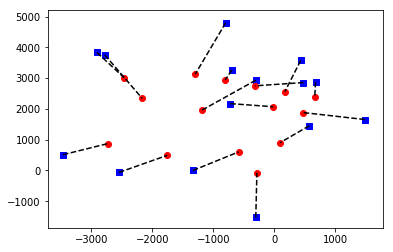

In [15]:
for (_, yt), (_, yp) in zip(yy_true.iterrows(), pso.predict(XX).iterrows()):
    plt.scatter(yt['x_center'], yt['y_center'], c='b', marker='s')
    plt.scatter(yp['x_center'], yp['y_center'], c='r', marker='o')
    plt.plot([yt['x_center'], yp['x_center']], [yt['y_center'], yp['y_center']], 'k--')

In [16]:
pso.estimator.x_center, pso.estimator.y_center, pso.estimator.rot

(-2016.7097117923443, 2000.0, -0.36937908126181856)

In [17]:
# 280*dva: 863413
# dva2ret: 773831
# prtrafo: 907130